# Dự báo chi phí điều trị bệnh đái tháo đường

## Giới thiệu

Dự án này nhằm xây dựng mô hình dự báo chi phí điều trị cho bệnh nhân đái tháo đường dựa trên các đặc điểm nhân khẩu học, thông tin y tế và các yếu tố khác. Việc dự báo chi phí điều trị có ý nghĩa quan trọng trong việc lập kế hoạch tài chính cho cả bệnh nhân và hệ thống y tế.

### Mục tiêu
- Phân tích các yếu tố ảnh hưởng đến chi phí điều trị bệnh đái tháo đường
- Xây dựng mô hình dự báo chi phí điều trị
- Đánh giá hiệu suất của các mô hình khác nhau
- Xác định mô hình tối ưu cho việc dự báo

### Cấu trúc dự án

1. Chuẩn bị môi trường và thư viện
2. Chuẩn bị dữ liệu
3. Khám phá và phân tích dữ liệu (EDA)
4. Tiền xử lý dữ liệu
5. Xây dựng và huấn luyện mô hình
6. Đánh giá mô hình
7. Kết luận và đề xuất

## 1. Chuẩn bị môi trường và thư viện

In [1]:
# Import các thư viện cần thiết
# Thư viện xử lý dữ liệu
import pandas as pd
import numpy as np

# Thư viện trực quan hóa dữ liệu
import matplotlib.pyplot as plt
import seaborn as sns

# Thư viện machine learning
import sklearn
from sklearn.experimental import enable_halving_search_cv
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.model_selection import cross_validate, train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


# Thư viện thống kê
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from scipy.stats import probplot
import pymc as pm
import arviz as az

# Các mô hình hồi quy
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.neural_network import MLPRegressor

# Thư viện thời gian
import time
import re
from datetime import timedelta

# Cấu hình hiển thị
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Tắt cảnh báo từ sklearn
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


In [2]:
# Kiểm tra phiên bản các thư viện
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Scikit-learn version:", sklearn.__version__)
print("XGBoost version:", xgb.__version__)
print("Matplotlib version:", plt.matplotlib.__version__)
print("Seaborn version:", sns.__version__)

NumPy version: 1.26.4
Pandas version: 2.2.0
Scikit-learn version: 1.5.1
XGBoost version: 2.1.3
Matplotlib version: 3.9.1
Seaborn version: 0.13.2


## 2. Chuẩn bị dữ liệu

### 2.1. Tải dữ liệu

In [5]:
# Đọc dữ liệu từ file CSV
df = pd.read_csv("E:/20250504_themtuyen_tonghop.csv")

# Hiển thị 5 dòng đầu tiên
df.head()

,MA_THE,type,Ky_QT_adjust,Tuoi,GIOI_TINH,So_Ngay_DTri_adjust,MA_LYDO_VVIEN,T_TONGCHI,T_BNTT,T_BHTT,T_BNCCT,T_BNT,T_XN,T_CDHA,T_Thuoc_adjust,T_MAU,T_TTPT,T_VTYT_adjust,T_DVKT_TYLE,T_KHAM,T_GIUONG,T_VCHUYEN,MA_LOAI_KCB,regions,HI,insurance,hang,diabetes,checkComorbidities,comorbidities,checkBienChung,soBienChung,diemBienChung,loaiBienChung,MA_CSKCB,tuyen
0,BT1279793027835,HCM,2018,83,1,1,1,60100.00,0.0,60100.00,0.0,0.0,0.0,0.0,36800.0,0.0,0.0,0.0,0.0,23300.0,0.00,0.0,1,Đồng Bằng Sông Hồng,Ngân sách Nhà nước đóng,100%,Không có hạng,E11,1,E78,1,2,2,MML,79517.0,"Quận, huyện và tương đương"
1,BT1279793027835,HCM,2018,83,1,1,1,128360.00,0.0,128360.00,0.0,0.0,21200.0,0.0,83860.0,0.0,0.0,0.0,0.0,23300.0,0.00,0.0,1,Đồng Bằng Sông Hồng,Ngân sách Nhà nước đóng,100%,Không có hạng,E11,1,E78,1,2,2,MML,79517.0,"Quận, huyện và tương đương"
2,BT1279793027835,HCM,2018,83,1,1,1,224820.00,0.0,224820.00,0.0,0.0,21200.0,0.0,180320.0,0.0,0.0,0.0,0.0,23300.0,0.00,0.0,1,Đồng Bằng Sông Hồng,Ngân sách Nhà nước đóng,100%,Không có hạng,E11,1,E78,1,2,2,MML,79517.0,"Quận, huyện và tương đương"
3,BT2010120220449,HCM,2019,85,1,1,1,37000.00,0.0,37000.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37000.0,0.00,0.0,1,Đồng Bằng Sông Hồng,Ngân sách Nhà nước đóng,100%,1,E11,0,Benh khac,0,0,0,Khong,79431.0,Trung ương
4,BT2010120230314,HCM,2020,81,2,12,1,27800067.96,0.0,27800067.96,0.0,0.0,3110100.0,163600.0,16405099.0,1950000.0,3633200.0,0.0,0.0,0.0,2538068.96,0.0,3,Đồng Bằng Sông Hồng,Ngân sách Nhà nước đóng,100%,1,E11,1,I10,0,0,0,Khong,79431.0,Trung ương


In [6]:
df = df[['Ky_QT_adjust', 'Tuoi', 'GIOI_TINH', 'So_Ngay_DTri_adjust',
       'MA_LYDO_VVIEN', 'MA_LOAI_KCB', 'regions', 'HI', 'insurance', 
       'tuyen', 'checkComorbidities', 'comorbidities', 'loaiBienChung', 
       'soBienChung', 'diemBienChung', "type", 'T_TONGCHI',]]

In [7]:
# Đổi tên cột
df.columns = ['Năm điều trị', 'Độ tuổi', 'Giới tính', 'Số ngày điều trị',
       'Lý do vào viện', 'Hình thức khám chữa bệnh', 'Vùng - khu vực đăng ký BHYT', 'Nhóm đối tượng tham gia BHYT', 'Mức hưởng BHYT',
       'Tuyến bệnh viện điều trị', 'Bệnh kèm', 'Loại bệnh kèm', 'Loại biến chứng',
       'Số biến chứng', 'Điểm biến chứng', 'Nơi điều trị', 'Tổng chi phí']

In [8]:
# Kiểm tra kích thước dữ liệu
print(f"Kích thước dữ liệu: {df.shape[0]} dòng x {df.shape[1]} cột")

Kích thước dữ liệu: 14277325 dòng x 17 cột


### 2.2. Xử lý dữ liệu lớn

Với kích thước dữ liệu lớn (hơn 14 triệu dòng), ta cần áp dụng các kỹ thuật để giảm thời gian xử lý và huấn luyện mô hình.

In [9]:
# Phương pháp 1: Lấy mẫu ngẫu nhiên từ dữ liệu
# Lấy mẫu 10% dữ liệu để phân tích nhanh hơn
sample_size = 0.1  # 10% dữ liệu
df_sampled = df.sample(frac=sample_size, random_state=42)
print(f"Kích thước dữ liệu sau khi lấy mẫu: {df_sampled.shape[0]} dòng x {df_sampled.shape[1]} cột")
print(f"Tỷ lệ so với dữ liệu gốc: {df_sampled.shape[0] / df.shape[0] * 100:.1f}%")

# Sử dụng df_sampled thay vì df cho các phân tích ban đầu và thử nghiệm mô hình
# Sau khi tìm được mô hình tốt nhất, có thể huấn luyện lại trên toàn bộ dữ liệu

Kích thước dữ liệu sau khi lấy mẫu: 1427732 dòng x 17 cột
Tỷ lệ so với dữ liệu gốc: 10.0%


In [18]:
# Kiểm tra thông tin cơ bản về dữ liệu
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14277325 entries, 0 to 14277324
Data columns (total 19 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   Năm điều trị                  int64  
 1   Độ tuổi                       int64  
 2   Giới tính                     int64  
 3   Số ngày điều trị              int64  
 4   Lý do vào viện                int64  
 5   Hình thức khám chữa bệnh      int64  
 6   Vùng - khu vực đăng ký BHYT   object 
 7   Nhóm đối tượng tham gia BHYT  object 
 8   Mức hưởng BHYT                object 
 9   Tuyến bệnh viện điều trị      object 
 10  Bệnh kèm                      int64  
 11  Loại bệnh kèm                 object 
 12  Loại biến chứng               object 
 13  Số biến chứng                 int64  
 14  Điểm biến chứng               int64  
 15  Nhóm tuổi                     object 
 16  Nơi điều trị                  object 
 17  Tổng chi phí                  float64
 18  log(Tổng chi phí)   

In [19]:
# Kiểm tra giá trị thiếu
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_data = pd.DataFrame({
    'Số giá trị thiếu': missing_values,
    'Phần trăm': missing_percentage
})

# Hiển thị các cột có giá trị thiếu
missing_data[missing_data['Số giá trị thiếu'] > 0].sort_values('Số giá trị thiếu', ascending=False)

,Số giá trị thiếu,Phần trăm


### 2.3. Tiền xử lý dữ liệu ban đầu

In [10]:
# Tạo cột log của "Tổng chi phí"
df["log(Tổng chi phí)"] = np.log(df["Tổng chi phí"])

# Xoá cột "Tổng chi phí"
df = df.drop(columns=["Tổng chi phí"])

# Tạo cột "Nhóm tuổi"
df["Nhóm tuổi"] = np.where(df["Độ tuổi"] < 40, 1,
                     np.where(df["Độ tuổi"] < 60, 2, 3))

# Tạo cột "Số biến chứng"
df["Số biến chứng"] = df["Số biến chứng"].apply(
    lambda x: "≥3" if x >= 3 else str(x)
)

# Tạo cột "Điểm biến chứng"
df["Điểm biến chứng"] = df["Điểm biến chứng"].apply(
    lambda x: "≥3" if x >= 3 else str(x)
)

In [15]:
# Đọc chỉ số đã lưu
idx = pd.read_csv("C:/Users/ncdhuy/Documents/augment-projects/diabetes/idx_sai_so_lon.csv").squeeze()  # chuyển thành Series

# Lọc điều kiện tương đương:
df = df[(df["Số ngày điều trị"] < 30) & (~df.index.isin(idx))]

In [16]:
# Chuyển đổi kiểu dữ liệu
categorical_columns = ['Giới tính', 'Lý do vào viện', 'Hình thức khám chữa bệnh', 'Bệnh kèm', 'Số biến chứng', 'Điểm biến chứng']
df[categorical_columns] = df[categorical_columns].astype('object')

# Kiểm tra dữ liệu sau khi xử lý
df.head()

,Năm điều trị,Độ tuổi,Giới tính,Số ngày điều trị,Lý do vào viện,Hình thức khám chữa bệnh,Vùng - khu vực đăng ký BHYT,Nhóm đối tượng tham gia BHYT,Mức hưởng BHYT,Tuyến bệnh viện điều trị,Bệnh kèm,Loại bệnh kèm,Loại biến chứng,Số biến chứng,Điểm biến chứng,Nơi điều trị,log(Tổng chi phí),Nhóm tuổi
0,2018,83,1,1,1,1,Đồng Bằng Sông Hồng,Ngân sách Nhà nước đóng,100%,"Quận, huyện và tương đương",1,E78,MML,2,2,HCM,11.003765,3
1,2018,83,1,1,1,1,Đồng Bằng Sông Hồng,Ngân sách Nhà nước đóng,100%,"Quận, huyện và tương đương",1,E78,MML,2,2,HCM,11.762594,3
2,2018,83,1,1,1,1,Đồng Bằng Sông Hồng,Ngân sách Nhà nước đóng,100%,"Quận, huyện và tương đương",1,E78,MML,2,2,HCM,12.323055,3
3,2019,85,1,1,1,1,Đồng Bằng Sông Hồng,Ngân sách Nhà nước đóng,100%,Trung ương,0,Benh khac,Khong,0,0,HCM,10.518673,3
4,2020,81,2,12,1,3,Đồng Bằng Sông Hồng,Ngân sách Nhà nước đóng,100%,Trung ương,1,I10,Khong,0,0,HCM,17.140549,3


In [13]:
# Thống kê mô tả cho các biến số
df.describe()

,Năm điều trị,Độ tuổi,Số ngày điều trị,log(Tổng chi phí),Nhóm tuổi
count,1.427732e+07,1.427732e+07,1.427732e+07,1.427732e+07,1.427732e+07
mean,2.020064e+03,6.329355e+01,1.342645e+00,1.305809e+01,2.627023e+00
std,1.401654e+00,1.146315e+01,3.649752e+00,9.284425e-01,5.394083e-01
min,2.018000e+03,1.800000e+01,1.000000e+00,4.330733e+00,1.000000e+00
25%,2.019000e+03,5.600000e+01,1.000000e+00,1.252195e+01,2.000000e+00
50%,2.020000e+03,6.400000e+01,1.000000e+00,1.306671e+01,3.000000e+00
75%,2.021000e+03,7.100000e+01,1.000000e+00,1.355647e+01,3.000000e+00
max,2.022000e+03,1.190000e+02,4.840000e+02,2.065743e+01,3.000000e+00


In [14]:
# Thống kê mô tả cho các biến phân loại
df.describe(include=['object'])

,Giới tính,Lý do vào viện,Hình thức khám chữa bệnh,Vùng - khu vực đăng ký BHYT,Nhóm đối tượng tham gia BHYT,Mức hưởng BHYT,Tuyến bệnh viện điều trị,Bệnh kèm,Loại bệnh kèm,Loại biến chứng,Số biến chứng,Điểm biến chứng,Nơi điều trị
count,14277325,14277325,14277325,14277325,14277325,14277325,14277325,14277325,14277325,14277325,14277325,14277325,14277325
unique,2,4,5,7,5,3,5,2,4,8,4,4,2
top,2,1,1,Đông Nam Bộ,Hộ gia đình đóng,80%,"Quận, huyện và tương đương",1,E78+I10,MML,1,1,HCM
freq,7828322,13111182,12740019,6820748,6373876,7834923,6733417,13979488,10526229,5766946,5318665,4396418,7337029


## 3. Phân tích khám phá dữ liệu (EDA)

### 3.1. Phân tích biến mục tiêu

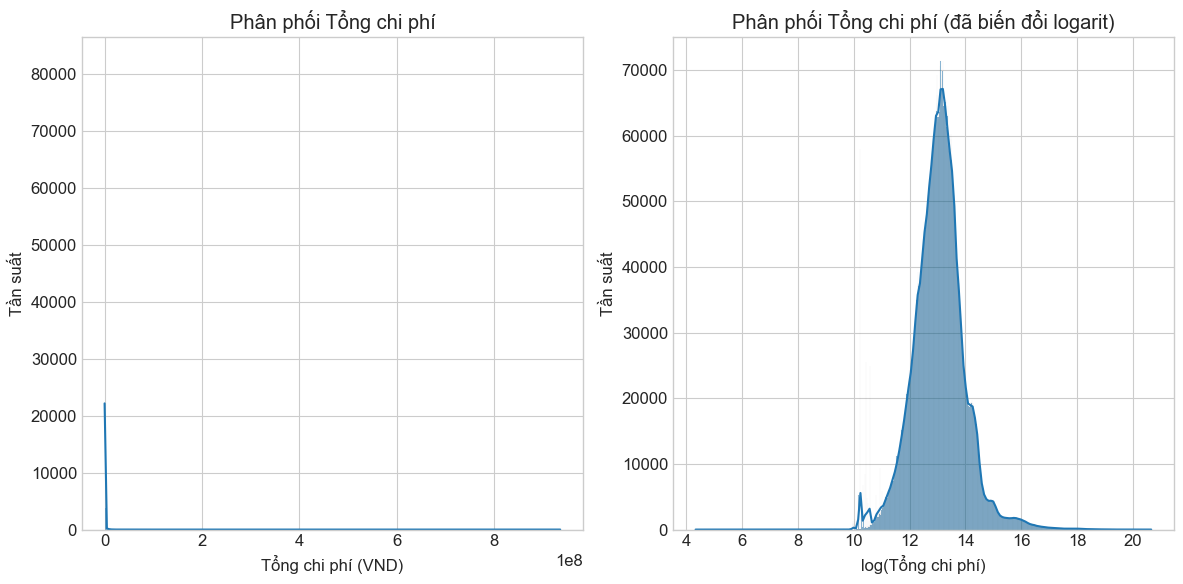

Nhận xét:
- Phân phối chi phí tổng ban đầu bị lệch phải mạnh (right-skewed)
- Sau khi biến đổi logarit, phân phối gần với phân phối chuẩn hơn
- Biến đổi logarit giúp cải thiện hiệu suất của các mô hình hồi quy


In [ ]:
# Phân tích phân phối của biến mục tiêu gốc (Tổng chi phí)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['Tổng chi phí'], kde=True)
plt.title('Phân phối Tổng chi phí')
plt.xlabel('Tổng chi phí (VND)')
plt.ylabel('Tần suất')

# Phân tích phân phối của biến mục tiêu sau khi biến đổi logarit
plt.subplot(1, 2, 2)
sns.histplot(df['log(Tổng chi phí)'], kde=True)
plt.title('Phân phối Tổng chi phí (đã biến đổi logarit)')
plt.xlabel('log(Tổng chi phí)')
plt.ylabel('Tần suất') 
plt.tight_layout()
plt.show()

# Giải thích lý do sử dụng biến đổi logarit
print("Nhận xét:")
print("- Phân phối Tổng chi phí ban đầu bị lệch phải mạnh (right-skewed)")
print("- Sau khi biến đổi logarit, phân phối gần với phân phối chuẩn hơn")
print("- Biến đổi logarit giúp cải thiện hiệu suất của các mô hình hồi quy")

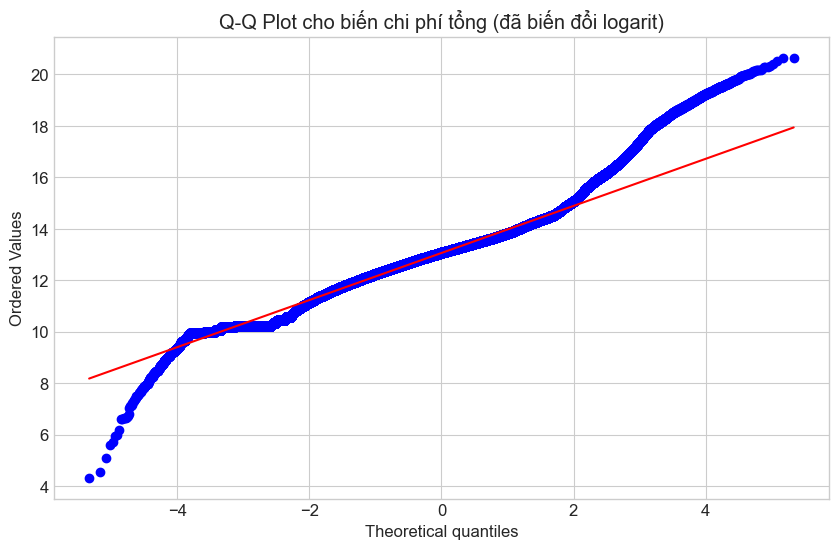

Nhận xét:
- Q-Q plot cho thấy biến đổi logarit đã cải thiện tính chuẩn của dữ liệu
- Vẫn có một số điểm lệch khỏi đường thẳng ở hai đầu, nhưng phần lớn dữ liệu đã phù hợp với phân phối chuẩn


In [ ]:
# Kiểm tra tính chuẩn của biến mục tiêu sau khi biến đổi logarit bằng Q-Q plot
plt.figure(figsize=(10, 6))
probplot(df['log(Tổng chi phí)'], plot=plt)
plt.title('Q-Q Plot cho biến Tổng chi phí (đã biến đổi logarit)')
plt.show()

print("Nhận xét:")
print("- Q-Q plot cho thấy biến đổi logarit đã cải thiện tính chuẩn của dữ liệu")
print("- Vẫn có một số điểm lệch khỏi đường thẳng ở hai đầu, nhưng phần lớn dữ liệu đã phù hợp với phân phối chuẩn")

### 3.2. Phân tích mối quan hệ giữa các biến

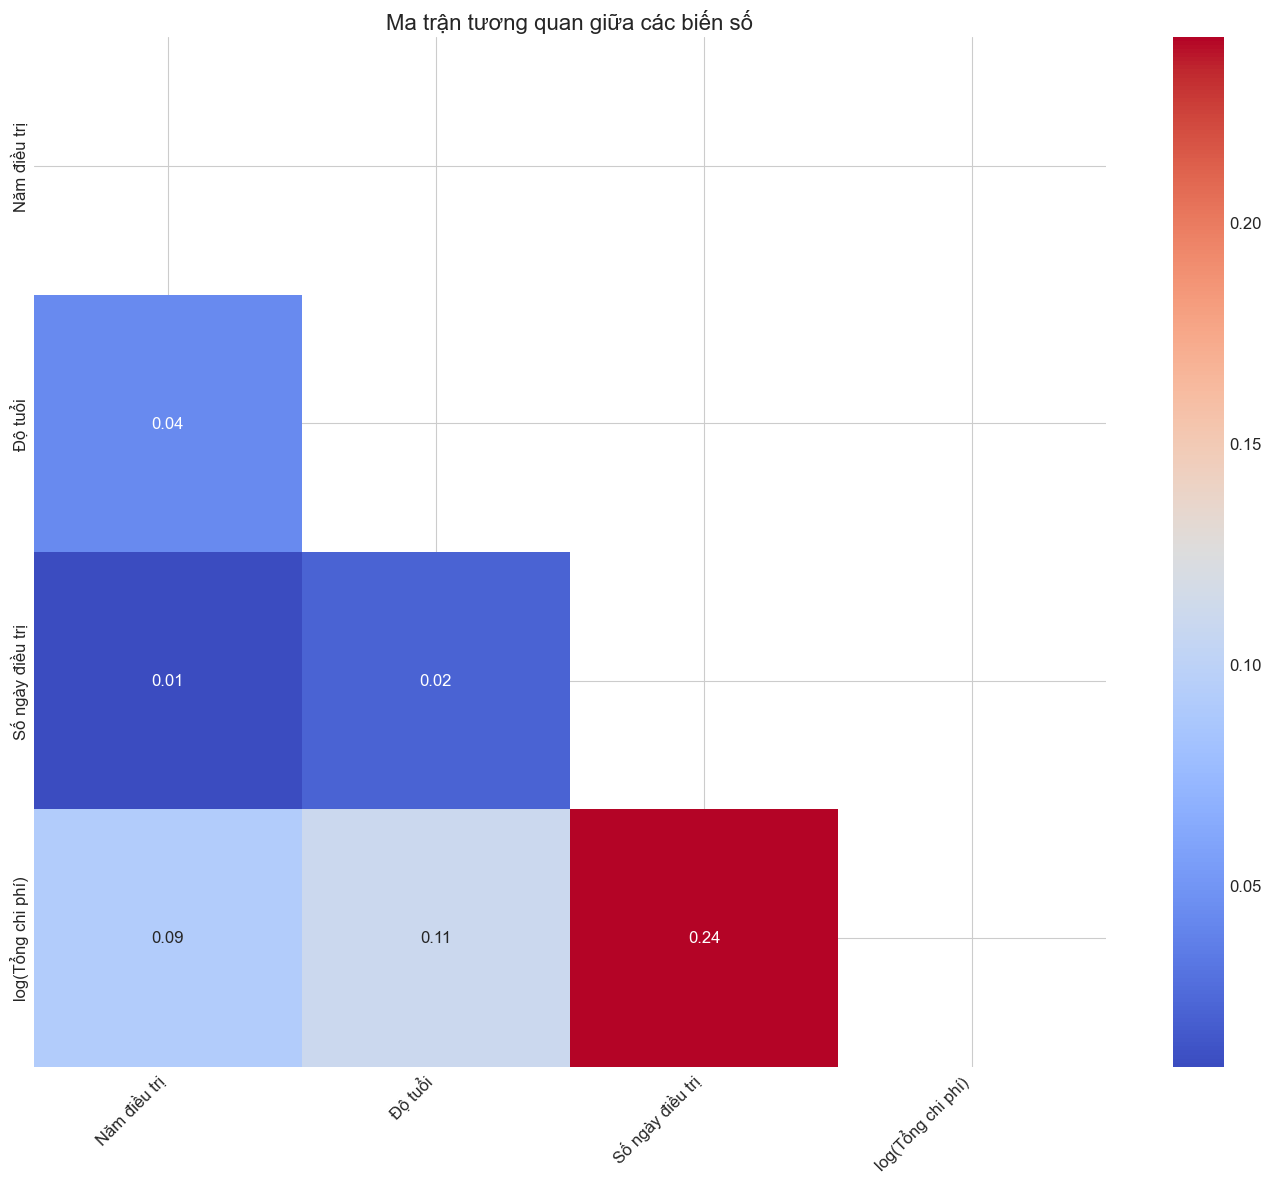

Tương quan với biến mục tiêu (log(Tổng chi phí)):
log(Tổng chi phí)    1.000000
Số ngày điều trị     0.241914
Độ tuổi              0.110466
Năm điều trị         0.092135
Name: log(Tổng chi phí), dtype: float64


In [68]:
# Ma trận tương quan giữa các biến số
numeric_df = df.select_dtypes(include=['float64', 'int64']).drop(columns=['Tổng chi phí'])
plt.figure(figsize=(14, 12))
correlation_matrix = numeric_df.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', mask=mask)
plt.title('Ma trận tương quan giữa các biến số', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Hiển thị các tương quan mạnh nhất với biến mục tiêu
target_correlations = correlation_matrix['log(Tổng chi phí)'].sort_values(ascending=False)
print("Tương quan với biến mục tiêu (log(Tổng chi phí)):")
print(target_correlations)

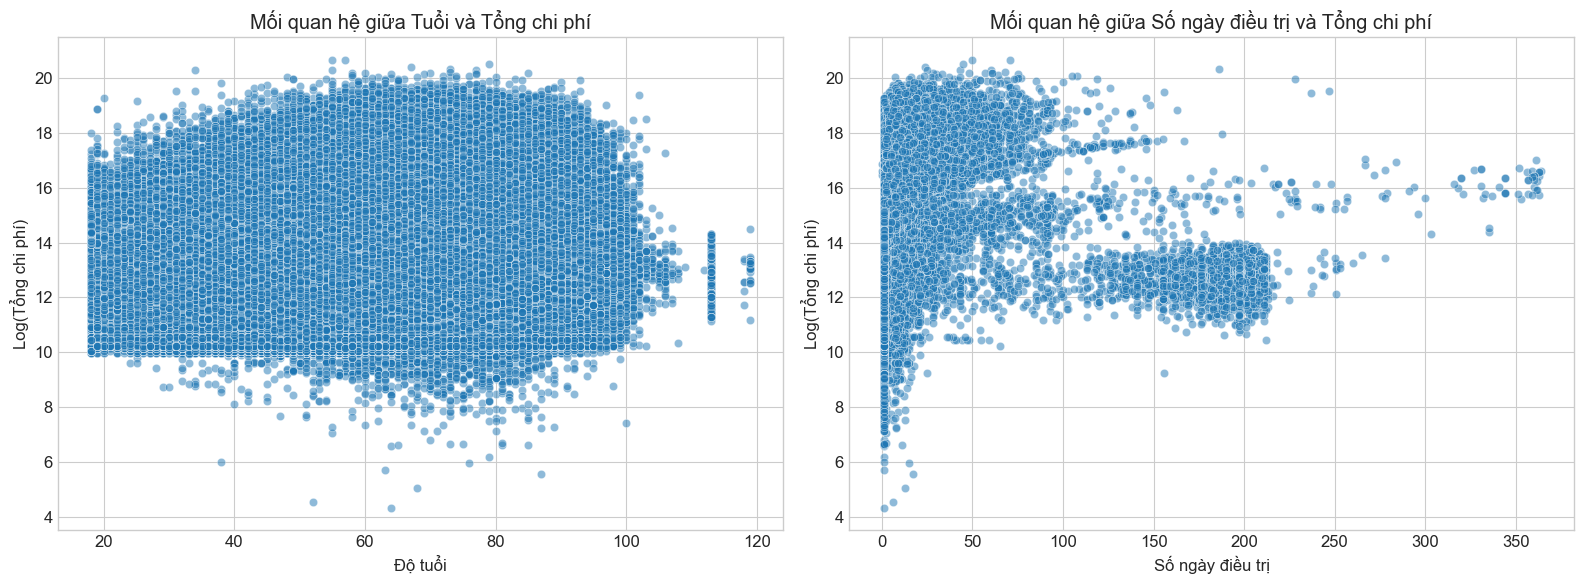

In [70]:
# Phân tích mối quan hệ giữa biến mục tiêu và các biến số quan trọng
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Mối quan hệ với tuổi
sns.scatterplot(x='Độ tuổi', y='log(Tổng chi phí)', data=df, alpha=0.5, ax=axes[0])
axes[0].set_title('Mối quan hệ giữa Tuổi và Tổng chi phí')
axes[0].set_xlabel('Độ tuổi')
axes[0].set_ylabel('Log(Tổng chi phí)')

# Mối quan hệ với số ngày điều trị
sns.scatterplot(x='Số ngày điều trị', y='log(Tổng chi phí)', data=df, alpha=0.5, ax=axes[1])
axes[1].set_title('Mối quan hệ giữa Số ngày điều trị và Tổng chi phí')
axes[1].set_xlabel('Số ngày điều trị')
axes[1].set_ylabel('Log(Tổng chi phí)')

plt.tight_layout()
plt.show()

### 3.3. Phân tích biến phân loại

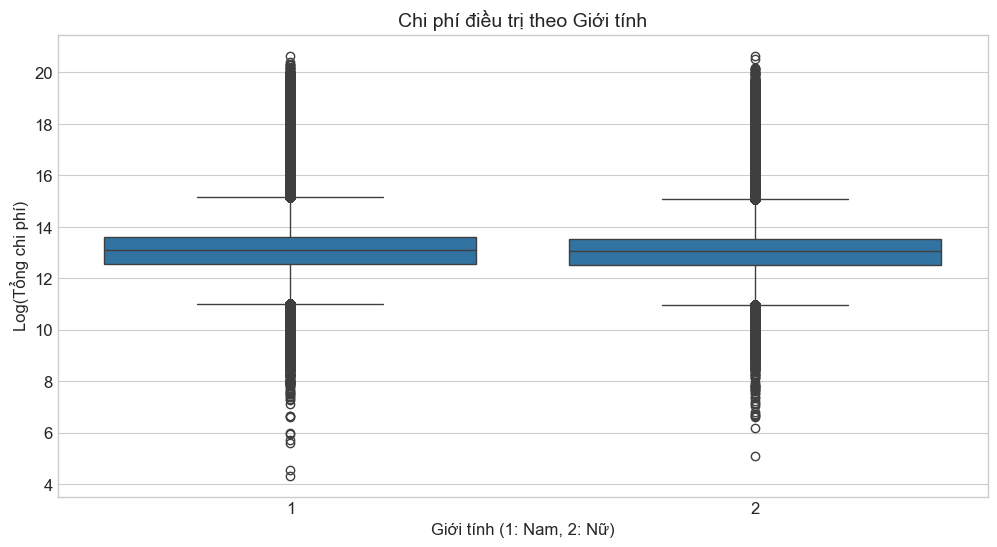

Thống kê chi phí theo giới tính:
                mean     median       std    count
Giới tính                                         
1          13.092893  13.094737  0.947722  6449003
2          13.029413  13.043576  0.911256  7828322


In [71]:
# Phân tích chi phí theo giới tính
plt.figure(figsize=(12, 6))
sns.boxplot(x='Giới tính', y='log(Tổng chi phí)', data=df)
plt.title('Chi phí điều trị theo Giới tính', fontsize=14)
plt.xlabel('Giới tính (1: Nam, 2: Nữ)')
plt.ylabel('Log(Tổng chi phí)')
plt.show()

# Thống kê chi phí trung bình theo giới tính
gender_stats = df.groupby('Giới tính')['log(Tổng chi phí)'].agg(['mean', 'median', 'std', 'count'])
print("Thống kê chi phí theo giới tính:")
print(gender_stats)

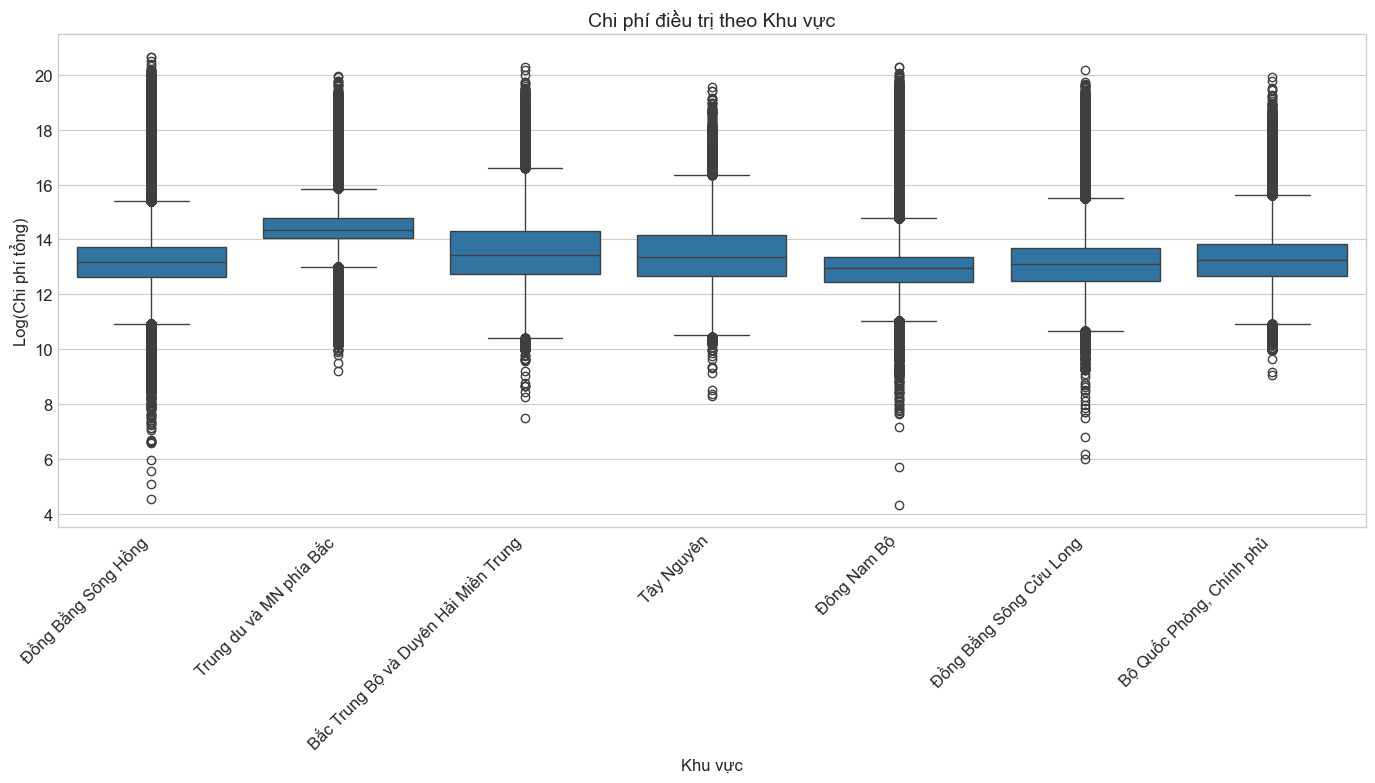

Thống kê chi phí theo khu vực (sắp xếp theo chi phí trung bình):
                                           mean     median       std    count
Vùng - khu vực đăng ký BHYT                                                  
Trung du và MN phía Bắc               14.398012  14.326638  1.022085   111074
Bắc Trung Bộ và Duyên Hải Miền Trung  13.583533  13.439093  1.305248   103302
Tây Nguyên                            13.481868  13.355795  1.272362    18121
Bộ Quốc Phòng, Chính phủ              13.261841  13.260994  0.983587   154564
Đồng Bằng Sông Hồng                   13.188288  13.179008  1.015945  6729020
Đồng Bằng Sông Cửu Long               13.173329  13.097415  1.058316   340496
Đông Nam Bộ                           12.888361  12.951233  0.761657  6820748


In [ ]:
# Phân tích chi phí theo khu vực
plt.figure(figsize=(14, 8))
sns.boxplot(x='Vùng - khu vực đăng ký BHYT', y='log(Tổng chi phí)', data=df)
plt.title('Chi phí điều trị theo Khu vực', fontsize=14)
plt.xlabel('Khu vực')
plt.ylabel('Log(Tổng chi phí)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Thống kê chi phí trung bình theo khu vực
region_stats = df.groupby('Vùng - khu vực đăng ký BHYT')['log(Tổng chi phí)'].agg(['mean', 'median', 'std', 'count']).sort_values('mean', ascending=False)
print("Thống kê chi phí theo khu vực (sắp xếp theo chi phí trung bình):")
print(region_stats)

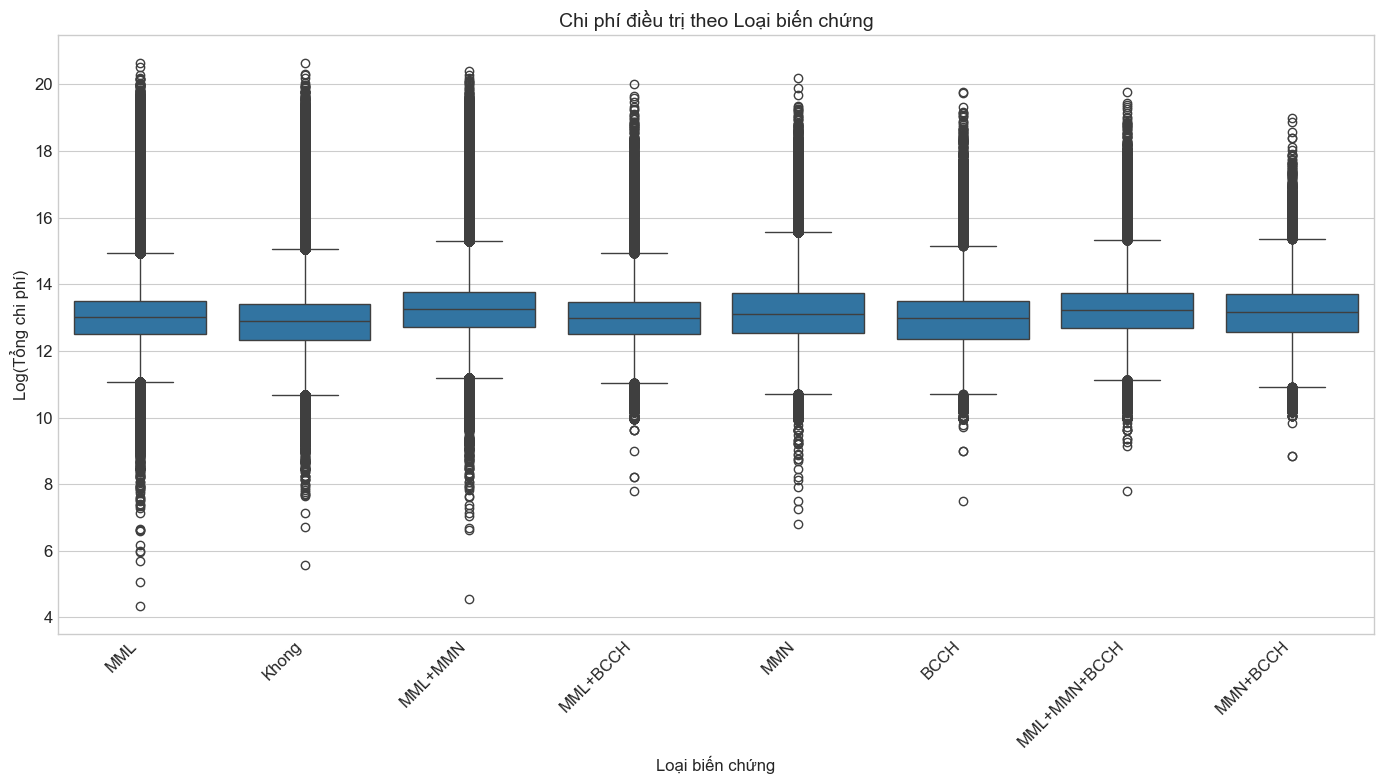

Thống kê chi phí theo loại biến chứng (sắp xếp theo chi phí trung bình):
                      mean     median       std    count
Loại biến chứng                                         
MML+MMN          13.258706  13.244022  0.949468  3652538
MML+MMN+BCCH     13.250968  13.242217  1.003202   118780
MMN              13.147744  13.121121  1.020014  1129329
MMN+BCCH         13.144267  13.163553  1.006451    33760
MML+BCCH         13.014999  13.000092  0.914650    92090
MML              13.010465  13.033314  0.855518  5766946
BCCH             12.980712  12.976049  1.017500    50626
Khong            12.889929  12.900578  0.944687  3433256


In [74]:
# Phân tích chi phí theo loại biến chứng
plt.figure(figsize=(14, 8))
sns.boxplot(x='Loại biến chứng', y='log(Tổng chi phí)', data=df)
plt.title('Chi phí điều trị theo Loại biến chứng', fontsize=14)
plt.xlabel('Loại biến chứng')
plt.ylabel('Log(Tổng chi phí)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Thống kê chi phí trung bình theo loại biến chứng
complication_stats = df.groupby('Loại biến chứng')['log(Tổng chi phí)'].agg(['mean', 'median', 'std', 'count']).sort_values('mean', ascending=False)
print("Thống kê chi phí theo loại biến chứng (sắp xếp theo chi phí trung bình):")
print(complication_stats)

### 3.4. Phân tích outliers (giá trị ngoại lai)

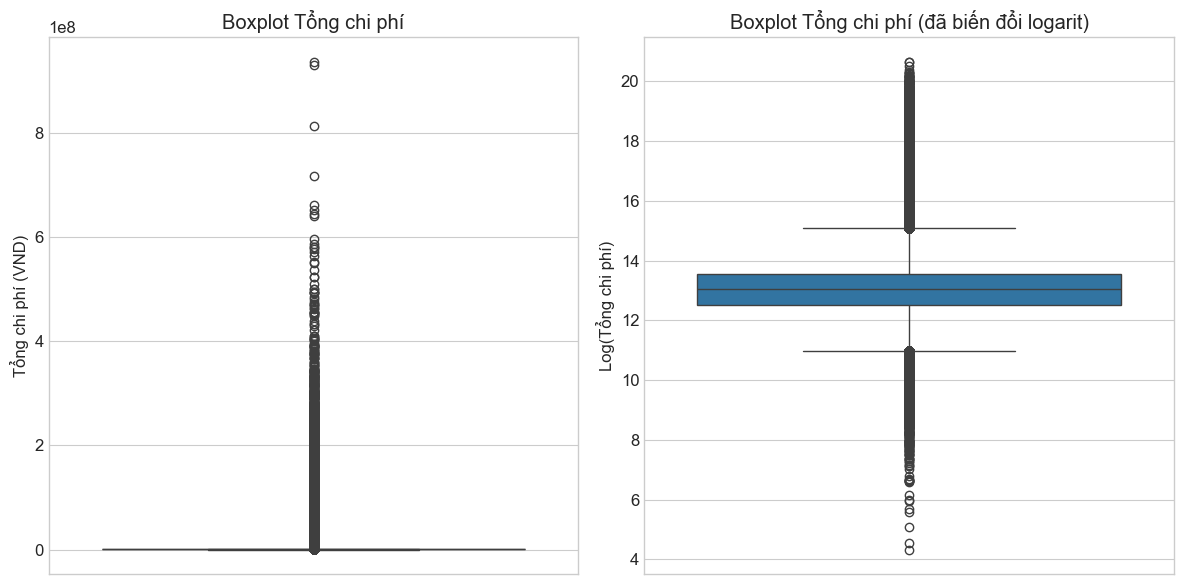

Số lượng outliers trong biến mục tiêu: 559913
Tỷ lệ outliers: 3.92%


In [75]:
# Kiểm tra outliers trong biến mục tiêu
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(y=df['Tổng chi phí'])
plt.title('Boxplot Tổng chi phí')
plt.ylabel('Tổng chi phí (VND)')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['log(Tổng chi phí)'])
plt.title('Boxplot Tổng chi phí (đã biến đổi logarit)')
plt.ylabel('Log(Tổng chi phí)')
plt.tight_layout()
plt.show()

# Xác định các outliers trong biến mục tiêu đã biến đổi logarit
Q1 = df['log(Tổng chi phí)'].quantile(0.25)
Q3 = df['log(Tổng chi phí)'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['log(Tổng chi phí)'] < lower_bound) | (df['log(Tổng chi phí)'] > upper_bound)]
print(f"Số lượng outliers trong biến mục tiêu: {len(outliers)}")
print(f"Tỷ lệ outliers: {len(outliers) / len(df) * 100:.2f}%")

## 4. Tiền xử lý dữ liệu

### 4.1. Xử lý dữ liệu thiếu và outliers

In [76]:
# Kiểm tra lại dữ liệu thiếu
print("Số lượng giá trị thiếu trong mỗi cột:")
print(df.isnull().sum())

# Nếu có dữ liệu thiếu, chúng ta có thể xử lý ở đây
# Ví dụ: df = df.dropna() hoặc df['column'].fillna(value)

# Quyết định về cách xử lý outliers
# Trong trường hợp này, chúng ta sẽ giữ lại outliers vì chúng có thể chứa thông tin quan trọng
# và biến đổi logarit đã giúp giảm ảnh hưởng của chúng
print("\nNhận xét về outliers:")
print("- Giữ lại outliers vì chúng có thể đại diện cho các trường hợp đặc biệt")
print("- Biến đổi logarit đã giúp giảm ảnh hưởng của outliers")
print("- Các mô hình như Random Forest và XGBoost ít bị ảnh hưởng bởi outliers")

Số lượng giá trị thiếu trong mỗi cột:
Năm điều trị                    0
Độ tuổi                         0
Giới tính                       0
Số ngày điều trị                0
Lý do vào viện                  0
Hình thức khám chữa bệnh        0
Vùng - khu vực đăng ký BHYT     0
Nhóm đối tượng tham gia BHYT    0
Mức hưởng BHYT                  0
Phân hạng CSKCB                 0
Tuyến bệnh viện điều trị        0
Bệnh kèm                        0
Loại bệnh kèm                   0
Loại biến chứng                 0
Số biến chứng                   0
Điểm biến chứng                 0
Nhóm tuổi                       0
Nơi điều trị                    0
Tổng chi phí                    0
log(Tổng chi phí)               0
dtype: int64

Nhận xét về outliers:
- Giữ lại outliers vì chúng có thể đại diện cho các trường hợp đặc biệt
- Biến đổi logarit đã giúp giảm ảnh hưởng của outliers
- Các mô hình như Random Forest và XGBoost ít bị ảnh hưởng bởi outliers


### 4.2. Chuẩn bị dữ liệu cho mô hình hóa

In [17]:
# Định nghĩa biến mục tiêu và các biến đầu vào
y = df['log(Tổng chi phí)']
X = df.drop(['log(Tổng chi phí)'], axis=1)

# Phân chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Kích thước tập huấn luyện: {X_train.shape[0]} mẫu")
print(f"Kích thước tập kiểm tra: {X_test.shape[0]} mẫu")

Kích thước tập huấn luyện: 11401402 mẫu
Kích thước tập kiểm tra: 2850351 mẫu


In [18]:
# Phân loại các biến thành biến số và biến phân loại
categorical_features = ['Giới tính', 'Lý do vào viện', 'Hình thức khám chữa bệnh',
       'Vùng - khu vực đăng ký BHYT', 'Nhóm đối tượng tham gia BHYT',
       # 'Phân hạng CSKCB', 
       'Bệnh kèm', 'Loại bệnh kèm', 'Loại biến chứng', 'Nơi điều trị']

ordinal_features = ['Mức hưởng BHYT', 'Tuyến bệnh viện điều trị', 'Số biến chứng',
       'Điểm biến chứng', 'Nhóm tuổi']

numerical_features = ['Năm điều trị', 'Độ tuổi', 'Số ngày điều trị']

# Kiểm tra các biến phân loại
print("Số lượng giá trị duy nhất trong mỗi biến phân loại:")
for feature in categorical_features:
    print(f"{feature}: {X[feature].nunique()} giá trị duy nhất")

Số lượng giá trị duy nhất trong mỗi biến phân loại:
Giới tính: 2 giá trị duy nhất
Lý do vào viện: 4 giá trị duy nhất
Hình thức khám chữa bệnh: 5 giá trị duy nhất
Vùng - khu vực đăng ký BHYT: 7 giá trị duy nhất
Nhóm đối tượng tham gia BHYT: 5 giá trị duy nhất
Bệnh kèm: 2 giá trị duy nhất
Loại bệnh kèm: 4 giá trị duy nhất
Loại biến chứng: 8 giá trị duy nhất
Nơi điều trị: 2 giá trị duy nhất


In [29]:
df.columns

Index(['Năm điều trị', 'Độ tuổi', 'Giới tính', 'Số ngày điều trị',
       'Lý do vào viện', 'Hình thức khám chữa bệnh',
       'Vùng - khu vực đăng ký BHYT', 'Nhóm đối tượng tham gia BHYT',
       'Mức hưởng BHYT', 'Tuyến bệnh viện điều trị', 'Bệnh kèm',
       'Loại bệnh kèm', 'Loại biến chứng', 'Số biến chứng', 'Điểm biến chứng',
       'Nơi điều trị', 'log(Tổng chi phí)', 'Nhóm tuổi'],
      dtype='object')

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14251753 entries, 0 to 14277324
Data columns (total 18 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   Năm điều trị                  int64  
 1   Độ tuổi                       int64  
 2   Giới tính                     object 
 3   Số ngày điều trị              int64  
 4   Lý do vào viện                object 
 5   Hình thức khám chữa bệnh      object 
 6   Vùng - khu vực đăng ký BHYT   object 
 7   Nhóm đối tượng tham gia BHYT  object 
 8   Mức hưởng BHYT                object 
 9   Tuyến bệnh viện điều trị      object 
 10  Bệnh kèm                      object 
 11  Loại bệnh kèm                 object 
 12  Loại biến chứng               object 
 13  Số biến chứng                 object 
 14  Điểm biến chứng               object 
 15  Nơi điều trị                  object 
 16  log(Tổng chi phí)             float64
 17  Nhóm tuổi                     int64  
dtypes: float64(1), int64(4), 

In [21]:
# Tạo pipeline tiền xử lý dữ liệu
# Xử lý biến số: chuẩn hóa
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Xử lý biến phân loại: one-hot encoding
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Kết hợp các bước tiền xử lý
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
        ('ord', ordinal_transformer, ordinal_features),
    ])

# Kiểm tra số lượng đặc trưng sau khi tiền xử lý
preprocessed_X_train = preprocessor.fit_transform(X_train)
print(f"Số lượng đặc trưng sau khi tiền xử lý: {preprocessed_X_train.shape[1]}")


Đã lưu preprocessor thành công!


In [22]:
feature_names = []
for name, transformer, cols in preprocessor.transformers_:
    if name == 'remainder':
        continue
    if hasattr(transformer, 'get_feature_names_out'):
        names = transformer.get_feature_names_out(cols)
    else:
        names = cols  # nếu không có .get_feature_names_out (ví dụ với StandardScaler)
    feature_names.extend(names)

print(feature_names)

['Năm điều trị', 'Độ tuổi', 'Số ngày điều trị', 'Giới tính_1', 'Giới tính_2', 'Lý do vào viện_1', 'Lý do vào viện_2', 'Lý do vào viện_3', 'Lý do vào viện_4', 'Hình thức khám chữa bệnh_1', 'Hình thức khám chữa bệnh_2', 'Hình thức khám chữa bệnh_3', 'Hình thức khám chữa bệnh_7', 'Hình thức khám chữa bệnh_9', 'Vùng - khu vực đăng ký BHYT_Bắc Trung Bộ và Duyên Hải Miền Trung', 'Vùng - khu vực đăng ký BHYT_Bộ Quốc Phòng, Chính phủ', 'Vùng - khu vực đăng ký BHYT_Trung du và MN phía Bắc', 'Vùng - khu vực đăng ký BHYT_Tây Nguyên', 'Vùng - khu vực đăng ký BHYT_Đông Nam Bộ', 'Vùng - khu vực đăng ký BHYT_Đồng Bằng Sông Cửu Long', 'Vùng - khu vực đăng ký BHYT_Đồng Bằng Sông Hồng', 'Nhóm đối tượng tham gia BHYT_Hộ gia đình đóng', 'Nhóm đối tượng tham gia BHYT_Ngân sách Nhà nước hỗ trợ đóng', 'Nhóm đối tượng tham gia BHYT_Ngân sách Nhà nước đóng', 'Nhóm đối tượng tham gia BHYT_Người lao động, người sử dụng lao động đóng', 'Nhóm đối tượng tham gia BHYT_Tổ chức BHXH đóng', 'Bệnh kèm_0', 'Bệnh kèm_1', 

## 5. Xây dựng và đánh giá mô hình

### 5.0. Tối ưu hóa hiệu suất cho dữ liệu lớn

In [24]:
# Sử dụng dữ liệu mẫu để huấn luyện mô hình
sample_size = 0.1  # 10% dữ liệu
df_sampled = pd.concat([X_train, y_train], axis=1).sample(frac=sample_size, random_state=42)
print(f"Kích thước dữ liệu sau khi lấy mẫu: {df_sampled.shape[0]} dòng x {df_sampled.shape[1]} cột")

# Sử dụng df_sampled thay vì df cho các bước tiếp theo
# Định nghĩa biến mục tiêu và các biến đầu vào từ dữ liệu đã lấy mẫu
y = df_sampled['log(Tổng chi phí)']
X = df_sampled.drop(['log(Tổng chi phí)'], axis=1)

Kích thước dữ liệu sau khi lấy mẫu: 1140140 dòng x 18 cột


### 5.1. Định nghĩa các mô hình

#### 5.1.1. Định nghĩa các mô hình cơ bản

In [3]:
# Định nghĩa các mô hình cơ bản
models_basic = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42),
    'SVR': LinearSVR(random_state=42),
    'MLP': MLPRegressor(random_state=42, max_iter=1000)
}

models = models_basic

#### 5.1.2. Định nghĩa các mô hình tối ưu cho chi phí tính toán

In [39]:
# Định nghĩa các mô hình tối ưu cho chi phí tính toán
models_optimized = {
    # Các mô hình tuyến tính
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.001),
    'ElasticNet': ElasticNet(alpha=0.001),
    
    # Random Forest
    'Random Forest': RandomForestRegressor(
        n_estimators=50,       # Giảm số lượng cây (mặc định là 100)
        max_depth=10,          # Giới hạn độ sâu tối đa của cây
        min_samples_split=10,  # Tăng số lượng mẫu tối thiểu để phân tách
        min_samples_leaf=4,    # Tăng số lượng mẫu tối thiểu ở nút lá
        max_features='sqrt',   # Chỉ xem xét một tập con các đặc trưng
        n_jobs=-1,             # Sử dụng tất cả các lõi CPU
        random_state=42
    ),
    
    # XGBoost
    'XGBoost': xgb.XGBRegressor(
        # n_estimators=50,       # Giảm số lượng cây
        # max_depth=6,           # Giới hạn độ sâu
        # learning_rate=0.1,     # Tốc độ học
        # subsample=0.8,         # Lấy mẫu con từ dữ liệu
        # colsample_bytree=0.8,  # Lấy mẫu con từ các đặc trưng
        # tree_method='hist',    # Phương pháp xây dựng cây nhanh hơn
        n_jobs=-1,             # Sử dụng tất cả các lõi CPU
        random_state=42
    ),
    
    # SVR
    'SVR': LinearSVR(
        C=1.0,                # Tham số điều chỉnh
        epsilon=0.1,          # Biên độ ống
        dual=True,           # Sử dụng công thức primal (nhanh hơn với dữ liệu lớn)
        max_iter=1000,        # Giới hạn số vòng lặp
        random_state=42
    ),
    
    # MLP
    'MLP': MLPRegressor(
        hidden_layer_sizes=(50,),  # Giảm kích thước mạng
        max_iter=300,              # Giảm số vòng lặp tối đa
        early_stopping=True,       # Dừng sớm nếu không cải thiện
        validation_fraction=0.1,   # Phần dữ liệu dùng để xác thực
        n_iter_no_change=10,       # Số vòng lặp không cải thiện trước khi dừng
        random_state=42
    )
}

# Sử dụng mô hình tối ưu
models = models_optimized

# Hàm tính metrics
def r2_dev_exp(y_true_log, y_pred_log):
    y_true = np.exp(y_true_log)
    y_pred = np.exp(y_pred_log)
    eps = 1e-9
    dev_model = 2 * np.sum((y_true - y_pred) / y_pred - np.log(y_true / y_pred))
    y_mean = np.mean(y_true)
    dev_null = 2 * np.sum((y_true - y_mean) / y_mean - np.log(y_true / y_mean))
    return 1 - dev_model / dev_null

def rmse_exp(y_true_log, y_pred_log):
    return np.sqrt(mean_squared_error(np.exp(y_true_log), np.exp(y_pred_log)))

def mae_exp(y_true_log, y_pred_log):
    return mean_absolute_error(np.exp(y_true_log), np.exp(y_pred_log))

# Scoring dictionary
scoring = {
    'r2_deviance': make_scorer(r2_dev_exp, greater_is_better=True),
    'rmse_exp': make_scorer(rmse_exp, greater_is_better=False),
    'mae_exp': make_scorer(mae_exp, greater_is_better=False),
}

### 5.2. Đánh giá các mô hình bằng cross-validation

In [40]:
# Hàm đánh giá mô hình bằng cross-validation có tính thời gian
def evaluate_model(model, X, y_log, preprocessor, cv=5):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    start_time = time.time()
    cv_results = cross_validate(pipeline, X, y_log, cv=cv, scoring=scoring, return_train_score=True)
    training_time = time.time() - start_time

    results = {
        'R² (test)': cv_results['test_r2_deviance'].mean(),
        'RMSE (test)': -cv_results['test_rmse_exp'].mean(),
        'MAE (test)': -cv_results['test_mae_exp'].mean(),
        'R² (train)': cv_results['train_r2_deviance'].mean(),
        'RMSE (train)': -cv_results['train_rmse_exp'].mean(),
        'MAE (train)': -cv_results['train_mae_exp'].mean(),
        'Thời gian huấn luyện': str(timedelta(seconds=training_time))
    }

    return results

In [68]:
# Đánh giá tất cả các mô hình
results = {}
for name, model in models.items():
    print(f"Đang đánh giá mô hình: {name}...")
    results[name] = evaluate_model(model, X, y, preprocessor)
    print(f"Mô hình {name} đã hoàn thành trong: {results[name]['Thời gian huấn luyện']}")
    print(f"R² (test): {results[name]['R² (test)']:.4f}, RMSE (test): {results[name]['RMSE (test)']:.4f}")
    print("-" * 50)

# Tạo DataFrame kết quả
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('R² (test)', ascending=False)
results_df

Đang đánh giá mô hình: Linear Regression...
Mô hình Linear Regression đã hoàn thành trong: 0:00:27.886322
R² (test): 0.4729, RMSE (test): 2796334.9259
--------------------------------------------------
Đang đánh giá mô hình: Ridge...
Mô hình Ridge đã hoàn thành trong: 0:00:23.333807
R² (test): 0.4729, RMSE (test): 2796593.3455
--------------------------------------------------
Đang đánh giá mô hình: Lasso...
Mô hình Lasso đã hoàn thành trong: 0:00:33.785983
R² (test): 0.4702, RMSE (test): 2801723.1196
--------------------------------------------------
Đang đánh giá mô hình: ElasticNet...
Mô hình ElasticNet đã hoàn thành trong: 0:01:00.072316
R² (test): 0.4710, RMSE (test): 2800872.8842
--------------------------------------------------
Đang đánh giá mô hình: Random Forest...
Mô hình Random Forest đã hoàn thành trong: 0:00:50.794112
R² (test): 0.5397, RMSE (test): 2840879.6737
--------------------------------------------------
Đang đánh giá mô hình: XGBoost...
Mô hình XGBoost đã hoàn th

,R² (test),RMSE (test),MAE (test),R² (train),RMSE (train),MAE (train),Thời gian huấn luyện
XGBoost,0.588335,2664375.027684,397828.948515,0.594777,2588495.287886,390051.051825,0:00:31.620794
MLP,0.581178,2670683.642763,400926.218968,0.582383,2670239.698124,400135.711601,0:07:12.471982
Random Forest,0.539742,2840879.673661,433374.729469,0.542226,2830578.569309,431736.434099,0:00:50.794112
SVR,0.500237,2809408.718038,453576.531012,0.500274,2811126.07197,453600.964517,0:16:56.618118
Ridge,0.47288,2796593.345479,458043.375217,0.473,2797251.615043,458005.50444,0:00:23.333807
Linear Regression,0.472857,2796334.925905,458033.73658,0.472974,2797177.853762,457997.666456,0:00:27.886322
ElasticNet,0.471039,2800872.884196,458366.887644,0.471144,2801580.02141,458335.20059,0:01:00.072316
Lasso,0.470233,2801723.119593,458551.040692,0.470327,2802409.287104,458523.387182,0:00:33.785983


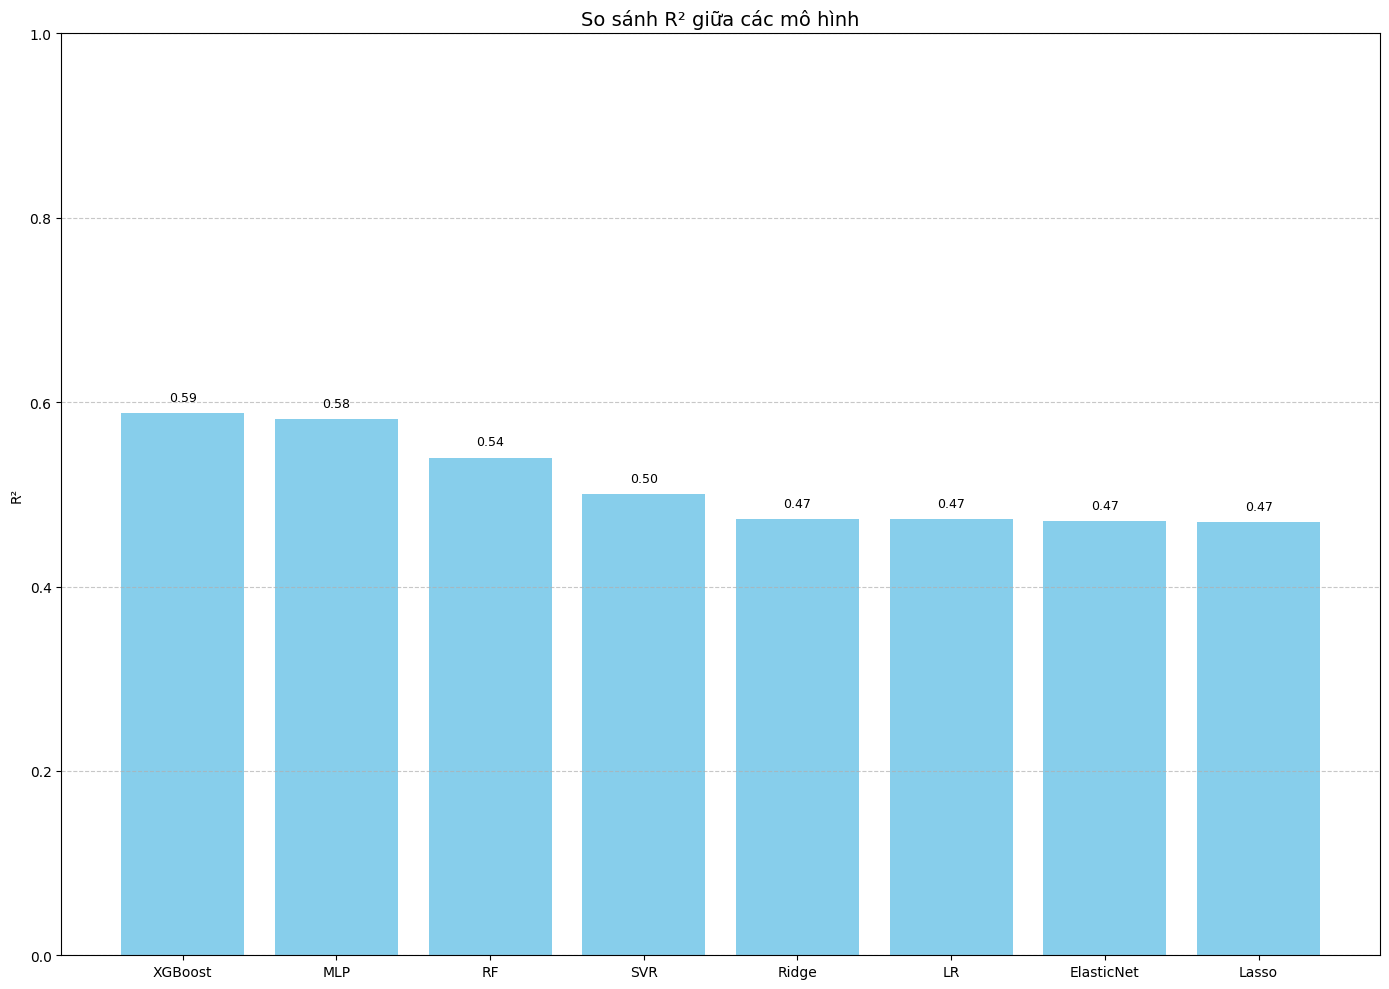

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))

# Biểu đồ R²
plt.subplot(1, 1, 1)
ax1 = plt.gca()
bars1 = ax1.bar(results_df['Model'], results_df['R² (test)'], color='skyblue')
plt.title('So sánh R² giữa các mô hình', fontsize=14)
plt.ylabel('R²')
plt.ylim(0, 1)
# plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Thêm nhãn cho từng cột
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

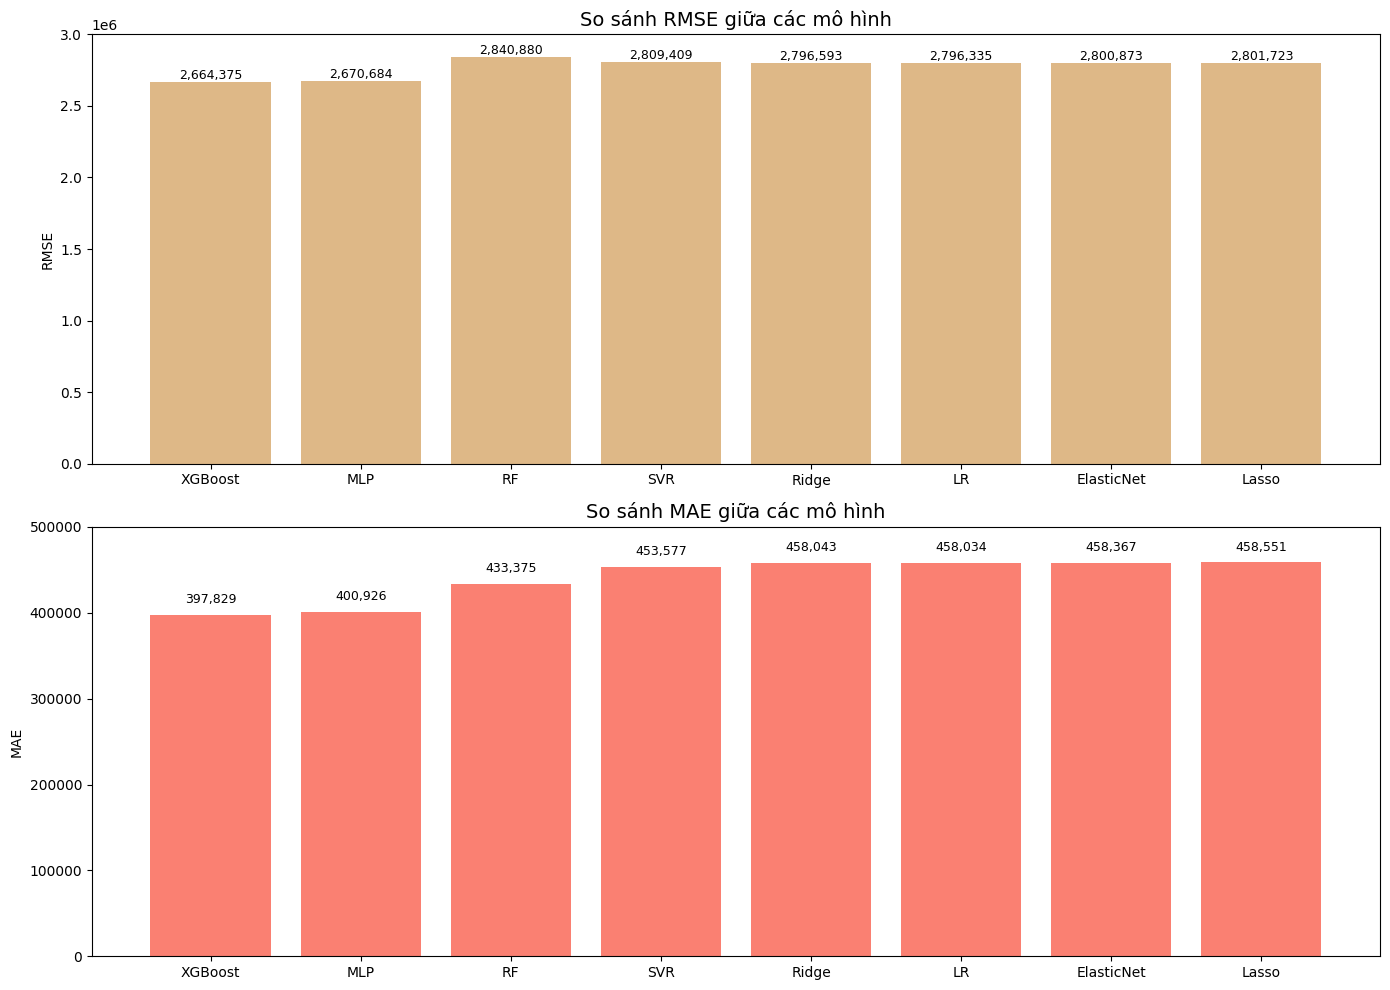

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))

# Biểu đồ R²
plt.subplot(2, 1, 1)
ax1 = plt.gca()
bars1 = ax1.bar(results_df['Model'], results_df['RMSE (test)'], color='burlywood')
plt.title('So sánh RMSE giữa các mô hình', fontsize=14)
plt.ylabel('RMSE')
plt.ylim(0, 3e6)
# plt.xticks(rotation=45, ha='right')
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# Thêm nhãn cho từng cột
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:,.0f}', ha='center', va='bottom', fontsize=9)

# Biểu đồ RMSE
plt.subplot(2, 1, 2)
ax2 = plt.gca()
bars2 = ax2.bar(results_df['Model'], results_df['MAE (test)'], color='salmon')
plt.title('So sánh MAE giữa các mô hình', fontsize=14)
plt.ylabel('MAE')
plt.ylim(0, 5e5)
# plt.xticks(rotation=45, ha='right')
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# Thêm nhãn cho từng cột
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height + 10000, f'{height:,.0f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


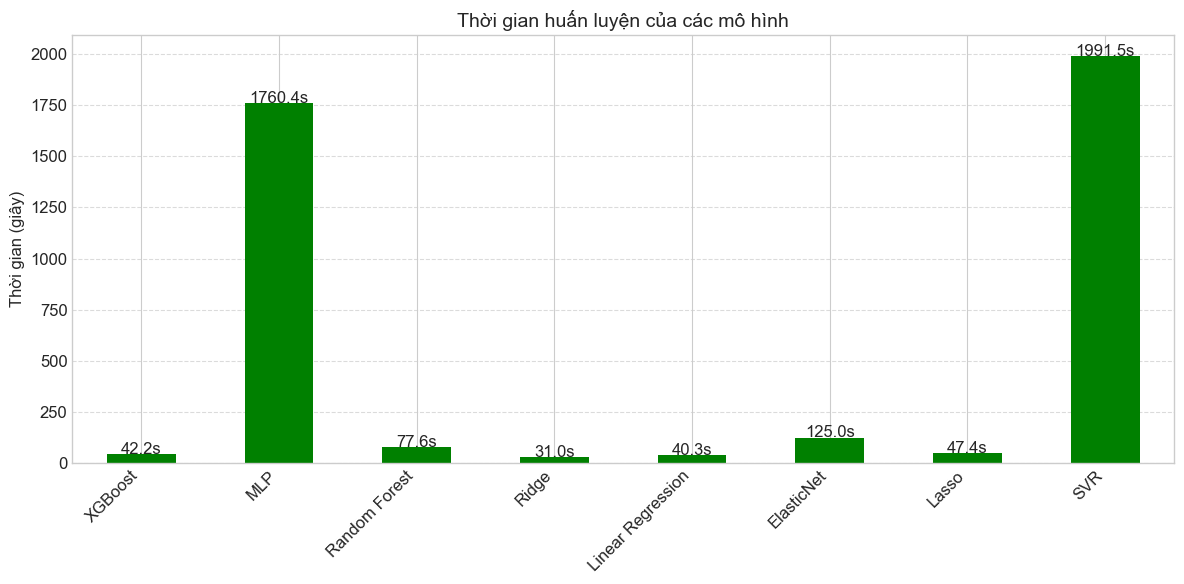

In [70]:
# Trực quan hóa thời gian huấn luyện
# Chuyển đổi chuỗi thời gian thành số giây

def time_to_seconds(time_str):
    # Mẫu: '0:00:12.345678'
    pattern = r'(\d+):(\d+):(\d+\.\d+)'
    match = re.match(pattern, time_str)
    if match:
        hours, minutes, seconds = match.groups()
        return int(hours) * 3600 + int(minutes) * 60 + float(seconds)
    return 0

# Tạo cột thời gian huấn luyện dưới dạng số giây
results_df['Thời gian (giây)'] = results_df['Thời gian huấn luyện'].apply(time_to_seconds)

# Vẽ biểu đồ thời gian huấn luyện
plt.figure(figsize=(12, 6))
results_df['Thời gian (giây)'].plot(kind='bar', color='green')
plt.title('Thời gian huấn luyện của các mô hình', fontsize=14)
plt.ylabel('Thời gian (giây)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Thêm nhãn thời gian lên mỗi cột
for i, v in enumerate(results_df['Thời gian (giây)']):
    plt.text(i, v + 0.1, f"{v:.1f}s", ha='center')

plt.tight_layout()
plt.show()

## 6. Phân tích mô hình tốt nhất

In [ ]:
# Chọn mô hình tốt nhất dựa trên kết quả cross-validation
best_model_name = results_df.index[0]
best_model = models_optimized[best_model_name]

print(f"Mô hình tốt nhất: {best_model_name}")
print(f"R² (cross-validation): {results_df.loc[best_model_name, 'R² (test)']:.4f}")
print(f"RMSE (cross-validation): {results_df.loc[best_model_name, 'RMSE (test)']:.4f}")

Mô hình tốt nhất: XGBoost
R² (cross-validation): 0.5883
RMSE (cross-validation): 2664375.0277


In [36]:
# Định nghĩa không gian tìm kiếm siêu tham số dựa trên loại mô hình
param_grid = {}

if best_model_name == 'Random Forest':
    param_grid = {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [10, 15, 20, None],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    }
elif best_model_name == 'XGBoost':
    param_grid = {
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [3, 6, 9],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__subsample': [0.8, 1.0],
        'model__colsample_bytree': [0.8, 1.0]
    }
elif best_model_name in ['Ridge', 'Lasso', 'ElasticNet']:
    param_grid = {
        'model__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
    }
    if best_model_name == 'ElasticNet':
        param_grid['model__l1_ratio'] = [0.1, 0.5, 0.7, 0.9]
elif best_model_name == 'SVR':
    param_grid = {
        'model__C': [0.1, 1.0, 10.0],
        'model__epsilon': [0.01, 0.1, 0.2]
    }
elif best_model_name == 'MLP':
    param_grid = {
        'model__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
        'model__activation': ['relu', 'tanh'],
        'model__alpha': [0.0001, 0.001, 0.01],
        'model__learning_rate': ['constant', 'adaptive']
    }

# Tạo pipeline cho GridSearchCV
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', best_model)
])

Tuning max_depth & min_child_weight

In [39]:
param_grid_1 = {
    'model__max_depth': [6, 8, 10],
    'model__min_child_weight': [1, 3, 5]
}

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(objective='reg:gamma', learning_rate=0.1, n_estimators=100, random_state=42),)
])

search_1 = HalvingGridSearchCV(
    pipeline,
    param_grid=param_grid_1,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

search_1.fit(X, y)
best_params_1 = search_1.best_params_

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 126682
max_resources_: 1140140
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 9
n_resources: 126682
Fitting 3 folds for each of 9 candidates, totalling 27 fits
----------
iter: 1
n_candidates: 3
n_resources: 380046
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 2
n_candidates: 1
n_resources: 1140138
Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [40]:
best_params_1

{'model__max_depth': 8, 'model__min_child_weight': 5}

Tuning gamma, reg_alpha & reg_lambda

In [43]:
param_grid_2 = {
    'model__gamma': [0, 0.1],
    'model__reg_alpha': [0.05, 0.1, 0.5],
    'model__reg_lambda': [1, 2, 3]
}

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(objective='reg:gamma', learning_rate=0.1, n_estimators=100, random_state=42, **best_params_1))
])

search_2 = HalvingGridSearchCV(
    pipeline,
    param_grid=param_grid_2,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

search_2.fit(X, y)
best_params_2 = {**best_params_1, **search_2.best_params_}

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 126682
max_resources_: 1140140
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 18
n_resources: 126682
Fitting 3 folds for each of 18 candidates, totalling 54 fits
----------
iter: 1
n_candidates: 6
n_resources: 380046
Fitting 3 folds for each of 6 candidates, totalling 18 fits
----------
iter: 2
n_candidates: 2
n_resources: 1140138
Fitting 3 folds for each of 2 candidates, totalling 6 fits


In [44]:
best_params_2

{'model__max_depth': 8,
 'model__min_child_weight': 5,
 'model__gamma': 0,
 'model__reg_alpha': 0.1,
 'model__reg_lambda': 1}

Tuning subsample & colsample_bytree

In [45]:
param_grid_3 = {
    'model__subsample': [1.0],
    'model__colsample_bytree': [0.4, 0.5, 0.6]
}

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(objective='reg:squarederror', learning_rate=0.1, n_estimators=100, random_state=42, **best_params_2))
])

search_3 = HalvingGridSearchCV(
    pipeline,
    param_grid=param_grid_3,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

search_3.fit(X, y)
best_params_3 = {**best_params_2, **search_3.best_params_}


n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 380046
max_resources_: 1140140
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 3
n_resources: 380046
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 1
n_candidates: 1
n_resources: 1140138
Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [46]:
best_params_3

{'model__max_depth': 8,
 'model__min_child_weight': 5,
 'model__gamma': 0,
 'model__reg_alpha': 0.1,
 'model__reg_lambda': 1,
 'model__colsample_bytree': 0.5,
 'model__subsample': 1.0}

In [41]:
best_params_3 = {'model__max_depth': 8,
 'model__min_child_weight': 5,
 'model__gamma': 0.1,
 'model__reg_alpha': 1,
 'model__reg_lambda': 3,
 'model__colsample_bytree': 0.5,
 'model__subsample': 1.0}

Huấn luyện mô hình trên toàn bộ tập huấn luyện

In [42]:
X_test_processed = preprocessor.transform(X_test)

In [44]:
# Cập nhật pipeline với learning_rate mới và n_estimators lớn
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(objective='reg:gamma', learning_rate=0.05, n_estimators=1000, random_state=42, **best_params_3,
                               eval_metric='rmse', early_stopping_rounds=20))
])

# Huấn luyện với early stopping
pipeline.fit(
    X_train, y_train,
    model__eval_set=[(X_test_processed, y_test)],
    model__verbose=False
)

y_pred = pipeline.predict(X_test)

In [46]:
import joblib

# Lưu pipeline đã huấn luyện
joblib.dump(pipeline, 'trained_pipeline_xgb.pkl')

# Load mô hình đã lưu
pipeline = joblib.load('trained_pipeline_xgb.pkl')

In [47]:
# In từng bước riêng lẻ
for name, step in pipeline.named_steps.items():
    print(f"{name}: {step}")

preprocessor: ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['Năm điều trị', 'Độ tuổi',
                                  'Số ngày điều trị']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Giới tính', 'Lý do vào viện',
                                  'Hình thức khám chữa bệnh',
                                  'Vùng - khu vực đăng ký BHYT',
                                  'Nhóm đối tượng tham gia BHYT', 'Bệnh kèm',
                                  'Loại bệnh kèm', 'Loại biến chứng',
                                  'Nơi điều trị']),
                                ('ord',
                                 Pipel

C:\Users\ncdhuy\AppData\Local\Temp\ipykernel_3548\1902028625.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')


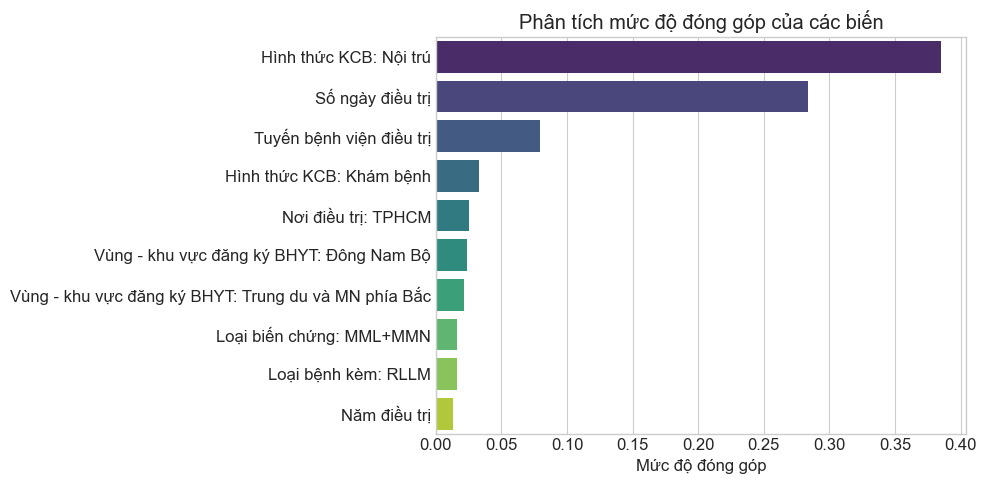

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Lấy model XGBoost thật sự
xgb_model = pipeline.named_steps['model']  # hoặc best_model.named_steps['model']

# 2️⃣ Lấy importances
importances = xgb_model.feature_importances_

# 3️⃣ Lấy feature names sau khi ColumnTransformer biến đổi
preprocessor = pipeline.named_steps['preprocessor']  # hoặc best_model.named_steps['preprocessor']

# --- Lấy tên cho từng nhóm ---
# numerical features
numerical_features = ['Năm điều trị', 'Độ tuổi', 'Số ngày điều trị']

# categorical features (one-hot)
categorical_features = [
    'Giới tính', 'Lý do vào viện', 'Hình thức khám chữa bệnh',
    'Vùng - khu vực đăng ký BHYT', 'Nhóm đối tượng tham gia BHYT',
    'Bệnh kèm', 'Loại bệnh kèm', 'Loại biến chứng', 'Nơi điều trị'
]
cat_feature_names = preprocessor.named_transformers_['cat'] \
                                 .named_steps['onehot'] \
                                 .get_feature_names_out(categorical_features)

# ordinal features
ordinal_features = ['Mức hưởng BHYT', 'Tuyến bệnh viện điều trị',
                    'Số biến chứng', 'Điểm biến chứng', 'Nhóm tuổi']

# Tổng hợp tất cả tên biến sau preprocessing
feature_names = list(numerical_features) + list(cat_feature_names) + list(ordinal_features)

# 4️⃣ Gộp tên biến và độ quan trọng
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).reset_index()

feature_importance_df.loc[0:9, 'Feature'] = ['Hình thức KCB: Nội trú', 'Số ngày điều trị', 'Tuyến bệnh viện điều trị', 
                                             'Hình thức KCB: Khám bệnh', 'Nơi điều trị: TPHCM', 'Vùng - khu vực đăng ký BHYT: Đông Nam Bộ',
                                             'Vùng - khu vực đăng ký BHYT: Trung du và MN phía Bắc', 'Loại biến chứng: MML+MMN',
                                             'Loại bệnh kèm: RLLM', 'Năm điều trị']

# 5️⃣ Vẽ biểu đồ
plt.figure(figsize=(10, len(feature_importance_df.head(10)) * 0.5))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')
plt.title('Phân tích mức độ đóng góp của các biến')
plt.xlabel('Mức độ đóng góp')
plt.ylabel('')
plt.tight_layout()
plt.show()


In [40]:
feature_importance_df.loc[0:9, "Feature"]

0                           Hình thức khám chữa bệnh_3
1                                     Số ngày điều trị
2                             Tuyến bệnh viện điều trị
3                           Hình thức khám chữa bệnh_1
4                                     Nơi điều trị_HCM
5              Vùng - khu vực đăng ký BHYT_Đông Nam Bộ
6    Vùng - khu vực đăng ký BHYT_Trung du và MN phí...
7                              Loại biến chứng_MML+MMN
8                                    Loại bệnh kèm_E78
9                                         Năm điều trị
Name: Feature, dtype: object

In [51]:
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

In [53]:
y_pred_train[:10]

array([12.556703 , 13.034625 , 14.148027 , 15.866421 , 13.337489 ,
       13.536304 , 12.690325 , 12.83417  , 13.2366495, 13.013901 ],
      dtype=float32)

Kết quả đánh giá mô hình tối ưu trên tập huấn luyện

In [51]:
print(r2_dev_exp(y_train, y_pred_train))
print(rmse_exp(y_train, y_pred_train))
print(mae_exp(y_train, y_pred_train))

0.5937053561723874
2693460.73939563
395788.48566691106


Kết quả đánh giá mô hình tối ưu trên tập kiểm tra

In [52]:
print(r2_dev_exp(y_test, y_pred_test))
print(rmse_exp(y_test, y_pred_test))
print(mae_exp(y_test, y_pred_test))

0.5936990484188391
2694103.755138548
396254.10698908195


## 7. Kết luận và đề xuất

### 7.1 Tóm tắt kết quả

Trong dự án này, chúng ta đã xây dựng và đánh giá nhiều mô hình dự báo chi phí điều trị cho bệnh nhân đái tháo đường. Các kết quả chính bao gồm:

1. **Phân tích dữ liệu**:
   - Phân phối chi phí điều trị ban đầu bị lệch phải mạnh, cần biến đổi logarit để chuẩn hóa
   - Các yếu tố như khám nội trú, số ngày điều trị, loại biến chứng, và khu vực đăng ký BHYT có ảnh hưởng đáng kể đến chi phí

2. **So sánh các mô hình**:
   - Các mô hình dựa trên cây quyết định (XGBoost, Random Forest) cho kết quả tốt nhất
   - Mô hình tốt nhất đạt được R² khoảng 0.60, cho thấy khả năng dự đoán trung bình


### 7.2 Hạn chế

Mặc dù đã đạt được một số kết quả khả quan, dự án vẫn còn một số hạn chế:

1. Khả năng dự đoán của mô hình ở mức trung bình.
2. Mô hình khảo sát chưa được nhiều (08 mô hình)

### 7.3 Đề xuất

Dựa trên kết quả phân tích, chúng tôi đề xuất:

1. **Cải thiện mô hình**:
   - Thu thập thêm dữ liệu trong tương lai
   - Thử nghiệm các kỹ thuật mô hình hóa nâng cao như stacking hoặc blending
   - Áp dụng kỹ thuật feature engineering phức tạp hơn

2. **Ứng dụng thực tế**:
   - Phát triển công cụ dự báo chi phí cho bệnh nhân và bác sĩ
   - Sử dụng kết quả để tối ưu hóa phân bổ nguồn lực y tế
   - Xây dựng hệ thống cảnh báo sớm cho các trường hợp có nguy cơ chi phí cao

3. **Nghiên cứu tiếp theo**:
   - Phân tích chi tiết hơn về mối quan hệ giữa các biến chứng và chi phí
   - So sánh chi phí điều trị đái tháo đường với các bệnh mãn tính khác
   - Nghiên cứu tác động của các chương trình can thiệp sớm đến chi phí dài hạn